# GAN / VAE Tutorial

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import and Set HyperParameters

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cpu')

In [ ]:
# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 28*28
num_epochs = 20
batch_size = 100
sample_dir = 'samples'

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)


transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
                                     std=[0.5])])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='./data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size,
                                          shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.03MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.46MB/s]


# 1. GAN

## Construct Class

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size, leaky=0.2):
        super(Discriminator, self).__init__()
        # 728 -> 256
        self.linear1 = nn.Linear(image_size, hidden_size)
        self.lr = nn.LeakyReLU(0.2)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.lr(x)
        x = self.linear2(x)
        x = self.lr(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, image_size):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(latent_size, hidden_size)
        # 64 -> 256
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        # 256->256
        self.linear3 = nn.Linear(hidden_size, image_size)
        # 256-> 728
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.tanh(x)
        return x

In [ ]:
D = Discriminator(image_size, hidden_size, leaky=0.2).to(device)

G = Generator(latent_size, hidden_size, image_size).to(device)

In [ ]:
D

Discriminator(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (lr): LeakyReLU(negative_slope=0.2)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
G

Generator(
  (linear1): Linear(in_features=64, out_features=256, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=784, bias=True)
  (tanh): Tanh()
)

In [ ]:
# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

# Device setting


In [ ]:
D = D.to(device)
G = G.to(device)

# Set Criterion and Optimizer

In [ ]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

# Useful Functions

In [ ]:
def denorm(x):
    # TANH (-1, 1)
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# Training GAN

In [ ]:
# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        # calculates gradient
        d_loss.backward()
        # Update parameters
        d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))

    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    torch.save(G.state_dict(), 'G.ckpt')
    torch.save(D.state_dict(), 'D.ckpt')

# Save the model checkpoints


Epoch [0/20], Step [200/600], d_loss: 0.0417, g_loss: 4.2083, D(x): 0.99, D(G(z)): 0.03
Epoch [0/20], Step [400/600], d_loss: 0.0843, g_loss: 6.1430, D(x): 0.96, D(G(z)): 0.04
Epoch [0/20], Step [600/600], d_loss: 0.0374, g_loss: 5.5000, D(x): 0.98, D(G(z)): 0.02
Epoch [1/20], Step [200/600], d_loss: 0.0474, g_loss: 5.3632, D(x): 0.98, D(G(z)): 0.02
Epoch [1/20], Step [400/600], d_loss: 0.0590, g_loss: 4.1932, D(x): 0.98, D(G(z)): 0.03
Epoch [1/20], Step [600/600], d_loss: 0.0715, g_loss: 5.1199, D(x): 0.98, D(G(z)): 0.04
Epoch [2/20], Step [200/600], d_loss: 0.1097, g_loss: 3.9013, D(x): 0.97, D(G(z)): 0.07
Epoch [2/20], Step [400/600], d_loss: 0.2322, g_loss: 3.8781, D(x): 0.94, D(G(z)): 0.09
Epoch [2/20], Step [600/600], d_loss: 0.8081, g_loss: 4.2188, D(x): 0.77, D(G(z)): 0.10
Epoch [3/20], Step [200/600], d_loss: 1.0350, g_loss: 2.8563, D(x): 0.75, D(G(z)): 0.17
Epoch [3/20], Step [400/600], d_loss: 0.4668, g_loss: 2.2929, D(x): 0.85, D(G(z)): 0.18
Epoch [3/20], Step [600/600], d_

# 2. VAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 64         # number of data points in each batch
N_EPOCHS = 20           # times to run the model on complete data
INPUT_DIM = 28 * 28     # size of each input
HIDDEN_DIM = 256        # hidden dimension
LATENT_DIM = 50         # latent vector dimension
lr = 1e-3               # learning rate

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transform)

test_dataset = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transform
)

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Construct Class

In [ ]:
class Encoder(nn.Module):
    ''' This the encoder part of VAE
    '''
    def __init__(self, input_dim, hidden_dim, z_dim):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            z_dim: A integer indicating the latent dimension.
        '''
        super(Encoder, self).__init__()

        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        # x is of shape [batch_size, input_dim]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]
        z_mu = self.mu(hidden)
        # z_mu is of shape [batch_size, latent_dim]
        z_var = self.var(hidden)
        # z_var is of shape [batch_size, latent_dim]
        # denotes for log(sigma^2)

        return z_mu, z_var

class Decoder(nn.Module):
    ''' This the decoder part of VAE
    '''
    def __init__(self, z_dim, hidden_dim, output_dim):
        '''
        Args:
            z_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the output dimension (in case of MNIST it is 28 * 28)
        '''
        super(Decoder, self).__init__()

        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x is of shape [batch_size, latent_dim]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]

        predicted = torch.sigmoid(self.out(hidden))
        # predicted is of shape [batch_size, output_dim]
        return predicted


class VAE(nn.Module):
    def __init__(self, enc, dec):
        ''' This the VAE, which takes a encoder and decoder.
        '''
        super(VAE, self).__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        # encode
        z_mu, z_var = self.enc(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        # decode
        predicted = self.dec(x_sample)
        return predicted, z_mu, z_var

In [ ]:
# encoder
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)

# decoder
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)

# vae
model = VAE(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train VAE

In [ ]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, (x, _) in enumerate(train_iterator):
        # reshape the data into [batch_size, 784]
        x = x.view(-1, 28 * 28)
        x = x.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample, z_mu, z_var = model(x)

        # reconstruction loss
        recon_loss = F.binary_cross_entropy(x_sample, x, reduction='sum')

        # kl divergence loss
        kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

        # total loss
        loss = recon_loss + kl_loss

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss


def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x, _) in enumerate(test_iterator):
            # reshape the data
            x = x.view(-1, 28 * 28)
            x = x.to(device)

            # forward pass
            x_sample, z_mu, z_var = model(x)

            # reconstruction loss
            recon_loss = F.binary_cross_entropy(x_sample, x, reduction='sum')

            # kl divergence loss
            kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

            # total loss
            loss = recon_loss + kl_loss
            test_loss += loss.item()

    return test_loss

best_test_loss = float('inf')

for e in range(N_EPOCHS):
    train_loss = train()
    test_loss = test()
    train_loss /= len(train_dataset)
    test_loss /= len(test_dataset)
    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1
    if patience_counter > 3:
        break

Epoch 0, Train Loss: 160.75, Test Loss: 130.44
Epoch 1, Train Loss: 124.02, Test Loss: 117.53
Epoch 2, Train Loss: 115.81, Test Loss: 112.78
Epoch 3, Train Loss: 112.26, Test Loss: 110.35
Epoch 4, Train Loss: 110.39, Test Loss: 109.02
Epoch 5, Train Loss: 109.21, Test Loss: 108.19
Epoch 6, Train Loss: 108.38, Test Loss: 107.63
Epoch 7, Train Loss: 107.79, Test Loss: 107.08
Epoch 8, Train Loss: 107.30, Test Loss: 106.56
Epoch 9, Train Loss: 106.96, Test Loss: 107.01
Epoch 10, Train Loss: 106.69, Test Loss: 105.93
Epoch 11, Train Loss: 106.34, Test Loss: 106.00
Epoch 12, Train Loss: 106.18, Test Loss: 105.48
Epoch 13, Train Loss: 105.95, Test Loss: 105.52
Epoch 14, Train Loss: 105.77, Test Loss: 105.09
Epoch 15, Train Loss: 105.57, Test Loss: 105.38
Epoch 16, Train Loss: 105.45, Test Loss: 104.84
Epoch 17, Train Loss: 105.30, Test Loss: 105.11
Epoch 18, Train Loss: 105.14, Test Loss: 104.69
Epoch 19, Train Loss: 105.01, Test Loss: 105.03


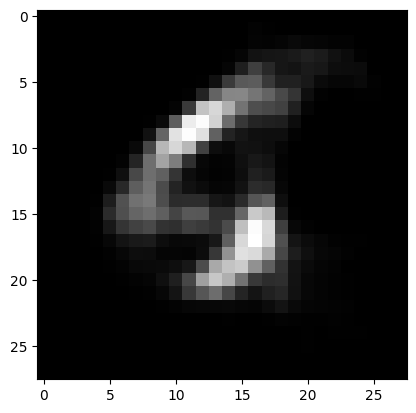

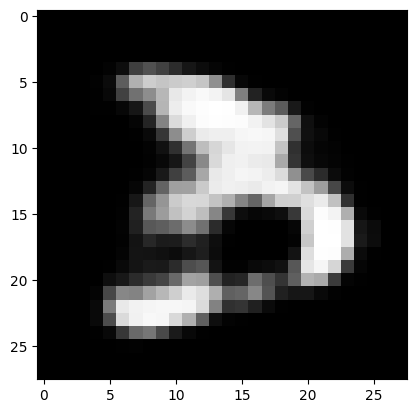

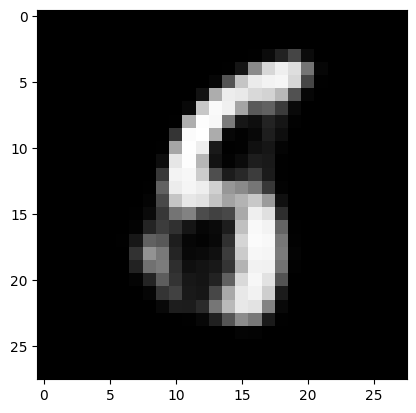

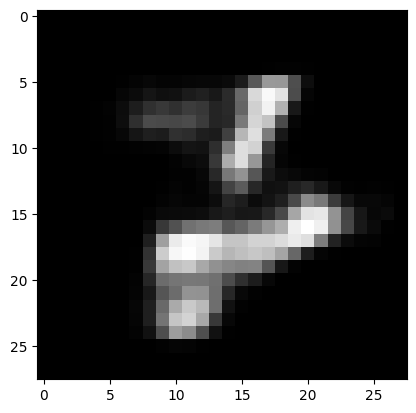

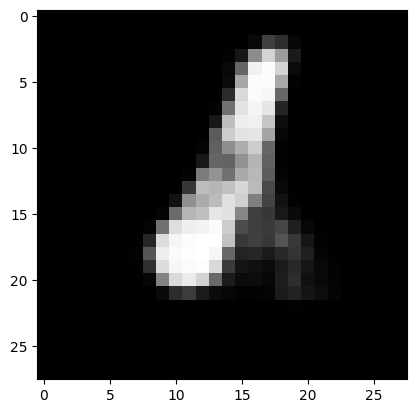

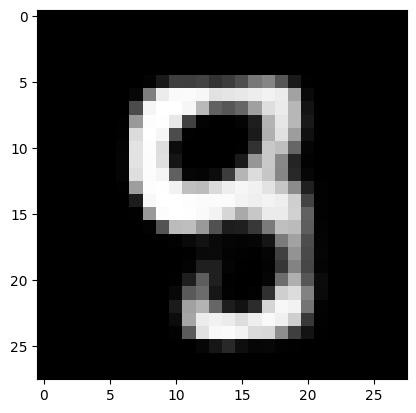

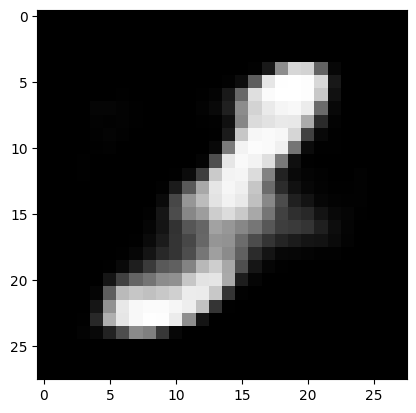

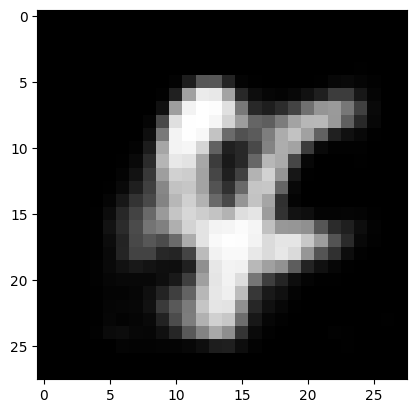

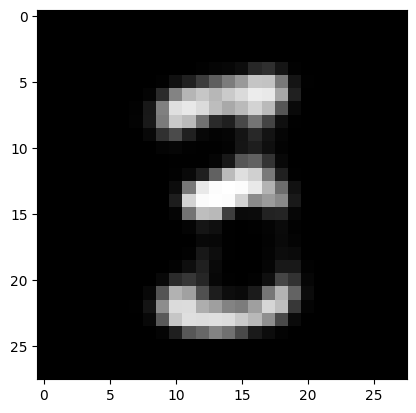

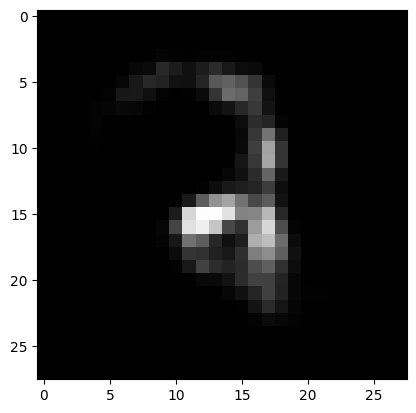

In [ ]:
# sample and generate a image
for i in range(10):
    z = torch.randn(1, LATENT_DIM).to(device)
    reconstructed_img = model.dec(z)
    img = reconstructed_img.cpu().view(28, 28).data

    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.show()

# Reference

https://github.com/graviraja/pytorch-sample-codes/blob/master/simple_vae.py

https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py